In [10]:
from scipy.integrate import solve_ivp
from math import sqrt, pi
import matplotlib.pyplot as plt
import numpy as np

# Plotting parameters
plt.rc("text", usetex=True)
plt.rc("font", family="serif", size=14)
plt.rc("lines", linewidth=2)
plt.rc("axes", grid=False)


In [ ]:
# Initial Pressures and Temperatures

T = 20 + 273.15  # K

# Dimensions

C_d = 0.4  # Discharge coefficient
L_p = 28.5e-3  # Length of piston (m)
L_low_bore = 0.4 # m
L_upp_bore = 0.17 + L_p # m 
D_p = 37.75e-3 # Diameter
h_fill = 0.36
A_s = 23.14e-3 * 124e-3# m^2 
A_p =  pi/4 * D_p**2 # piston area (m^2)
A_v = 1.4 * 10**-5  # valve orifice area (m^2)

# Scientific Constants
k = 1.3  # Specific heat ratio
R = 296.8  # J/kg.K
c_p = 1040  # J/kg.K
g = 9.81  # m/s^2

# Masses
rho_w = 1000  # Density of water (kg/m^3)
m_w = 0.54 # kg -- measured
m_piston = 0.0271  # Mass of pusher piston (kg)




0.001119241470226576

In [25]:
# Initial Conditions
ATM = 101325
x_p0 = 0  # Initial position pusher (m)
v_p0 = 0
x_s0 = x_p0 +  h_fill # Test section water height (m)
v_s0 = 0

p_r0 = 250 * 6895  # reservoir initial pressure in Pa
p_p0 = ATM  # initial pressure under pusher piston in Pa
p_s = ATM # Pa Pressure at the top surface 

# Initial Volumes
V_r = 517.9 * 10**-6  # Reservoir volume (m^3)
V_p0 = L_low_bore*A_p  # Volume under pusher piston (m^3)

m_r0 = p_r0 * V_r / (R * T)  # kg
m_p0 = p_p0 * V_p0 / (R * T)  # kg


y0 = [m_r0, p_r0, m_p0, p_p0, x_p0, v_p0, x_s0, v_s0]

p_r0 * A_p

1929.2924843030603

In [13]:
def ode(t,y):
    m_r = y[0]
    p_r = y[1]
    m_p = y[2]
    p_p = y[3]
    x_p = y[4]
    v_p = y[5]
    x_s = y[6]
    v_s = y[7]
    
    V_p = A_p * x_p + V_p0 # Volume under pusher piston (m^3) 

    if (p_p / p_r) < 0.5283:
        # Choked flow condition
        m_r_dot = C_d*(- A_v * p_r * sqrt(k / (R * T)) * (2 / (k + 1)) ** ((k + 1) / (2 * (k - 1))))
    else:
        # Unchoked flow condition
        m_r_dot = C_d * (-A_v * p_r / sqrt(R * T) * (p_p / p_r) ** (1 / k) * \
                sqrt((2 * k / (k - 1)) * (1 - (p_p / p_r) ** ((k - 1) / k))))


    p_r_dot = m_r_dot*k*R*T/V_r

    m_p_dot = -m_r_dot

    p_p_dot = 1/V_p * ((k+1)*c_p*m_p_dot*T-k*p_p*A_p*v_p)

    a_p = (- A_s*p_s + A_p*p_p - (m_w + m_piston)*g)/m_piston

    v_s = A_p/A_s * v_p

    a_s = (-A_s*p_s + A_p*p_p - m_w*g)/m_w

    if a_p < 0: #Prevent Piston from going below 0
        a_p = 0
        v_p = 0
        v_s = 0
        a_s = 0

    if x_p > L_upp_bore - L_p: # Prevent piston from going above length of upper bore
        x_p = L_upp_bore - L_p
        a_p = 0
        v_p = 0
        v_s = 0
        a_s = 0


    y_dot = [m_r_dot, p_r_dot, m_p_dot, p_p_dot, v_p, a_p, v_s, a_s]
    
    return y_dot

In [14]:
solution = solve_ivp(ode, t_span = (0,0.03), y0 = y0, method='RK23')

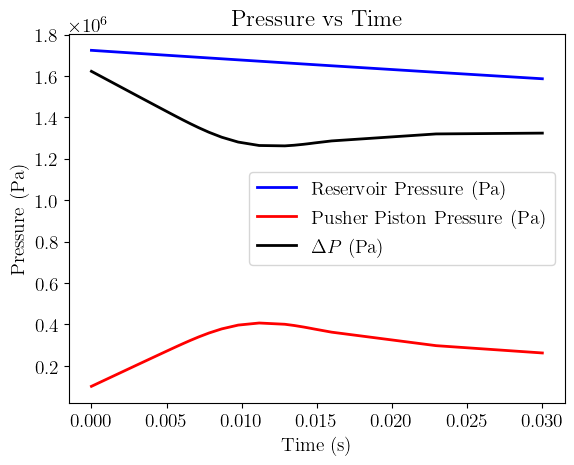

In [23]:
# Extract the solution
t = solution.t
y = solution.y

# Plot pressures
plt.figure()
plt.plot(t, y[1], label="Reservoir Pressure (Pa)", color = 'blue')
plt.plot(t, y[3], label="Pusher Piston Pressure (Pa)", color = 'red')
plt.plot(t, y[1]-y[3], label=r"$\Delta P$ (Pa)", color = 'k')
plt.xlabel('Time (s)')
plt.ylabel('Pressure (Pa)')
plt.legend()
plt.title('Pressure vs Time')
plt.show()

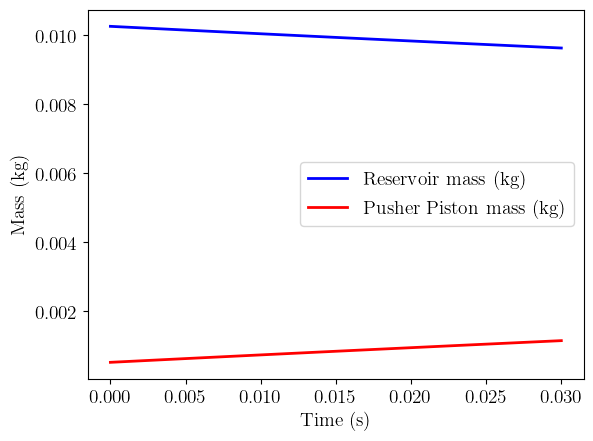

In [20]:
# Plot mass flow
plt.figure()
plt.plot(t, y[0], label="Reservoir mass (kg)", color = 'blue')
plt.plot(t, y[2], label="Pusher Piston mass (kg)", color = 'red')
plt.xlabel('Time (s)')
plt.ylabel('Mass (kg)')
plt.legend()
plt.show()

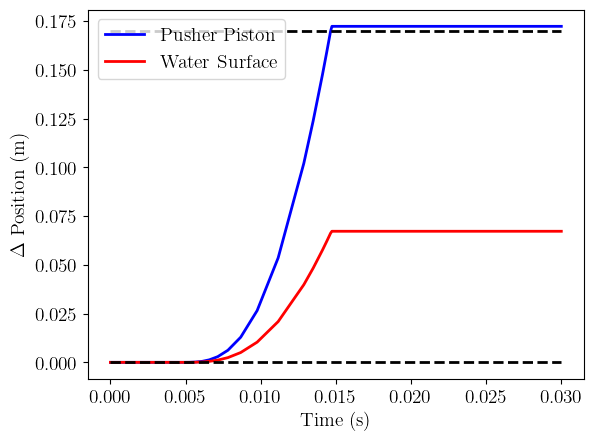

In [21]:
# Plot positions
plt.figure()
plt.plot(t, y[4]-min(y[4]), label=" Pusher Piston",  color = 'blue')
plt.plot(t, y[6]-min(y[6]), label="Water Surface", color = 'red')
plt.hlines(0,0,0.03, 'k', linestyles='--')
plt.hlines(L_upp_bore-L_p,0,0.03, 'k', linestyles='--')
plt.xlabel('Time (s)')
plt.ylabel(r'$\Delta$ Position (m)')
plt.legend()
plt.show()

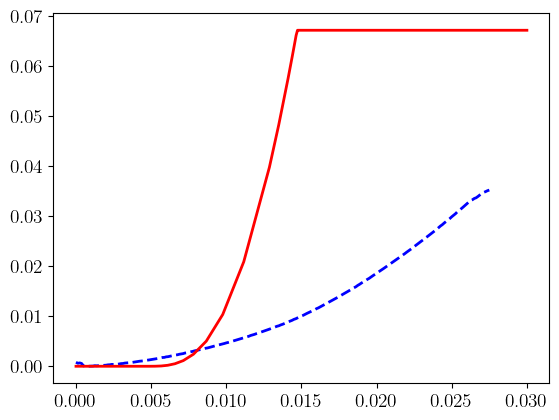

In [22]:
edges = np.load(r"./free_surface_data.npy")  # Load the saved array
y_values = edges[1, :, :] * 0.2  # Extract y-values
avg_y = np.mean(y_values, axis=0)/1000  # Compute average y-value per frame
time = np.arange(avg_y.shape[0]) / 8000  # Generate frame numbers
plt.plot(time, avg_y-np.min(avg_y), marker="none", linestyle="--", color="b", label="Avg Y")
plt.plot(t, y[6]-np.min(y[6]), label="Water Surface Position (m)", color = 'red')
plt.show()